# Example: PS-DTFE estimator for 3D simulation output — subbox routine

Before going through this notebook, please have a look at the `Example_3D.ipynb` notebook.


This notebook goes through the PS-DTFE subbox routine which allows for the evaluation of fields from higher-resolution simulations (> 128^3 particles). Here, The particles are divided into subboxes (defaulting to size 128^3) for which individual estimators are constructed, and from which fields are efficiently computed.

NOTE: While the code allows for subboxes of any size, subboxes greater than 128^3 particles require extensive working memory (> 100 GB) are impractical even in HPC applications.

For a typical 256^3 calculation, 8 subboxes of size 128^3 take a total of 10-30 minutes of construction time and 20-50 GB of storage space for depths 5-7 respectively.

Due to Gitub's file size limit, we use here a 64^3 simulation and construct subboxes of size 32^3.

author: Benjamin Hertzsch (benjamin.hertzsch@ed.ac.uk), Job Feldbrugge (job.feldbrugge@ed.ac.uk)


## Step 1: data preparation

In [4]:
using JLD2, Plots, HDF5, ProgressMeter

include("PS-DTFE_subbox.jl")

## set up simulation box
Ni = 64
L  = 100.

## load data 
function load_data(file)
    fid = h5open(file, "r")
    pos = convert.(Float64, read(fid["PartType1"]["Coordinates"]))
    vel = convert.(Float64, read(fid["PartType1"]["Velocities"]))
    ids = read(fid["PartType1"]["ParticleIDs"])
    time = read_attribute(fid["Header"], "Time")
    close(fid)

    ordering = sortperm(ids)
    return (copy(pos[:,ordering]'), copy(vel[:,ordering]'), time)
end

function load_mass(file)
    f = h5open(file, "r")
    read_attribute(f["Header"], "MassTable")[2]  # particle type 1
end

m = load_mass("data/snapshot_000.hdf5")
(coords_q, _, _) = load_data("data/snapshot_000.hdf5")
(coords_x, vels, _) = load_data("data/snapshot_002.hdf5")

## Do not modify data here. Processing is done directly in the subbox routine.


([95.94856262207031 98.76901245117188 99.14542388916016; 99.86626434326172 97.77499389648438 97.80353546142578; … ; 94.38851928710938 97.52845764160156 0.3155221939086914; 94.68167114257812 97.48580169677734 99.97648620605469], [-292.1794128417969 -76.47138977050781 28.625730514526367; -60.02801513671875 -113.5673599243164 -126.30517578125; … ; -395.4625244140625 163.2576141357422 155.2444610595703; -418.26104736328125 123.40419006347656 328.3358459472656], 0.9999999999999997)

## Step 2: estimator construction

The estimator construction is similar to the basic implementation case of `Example_3D.ipynb`.

Pass on the `sim_box`-struct to specify the box properties. Velocities can be omitted for efficiency; the `ps_dtfe_subbox()`-function is overloaded to allow for calling with or without the argument.

The estimator is constructed with default arguments `N_target=128` for the subbox size 128^3, `pad=0.05` for the framing width and `dir="./ps_dtfe"` for the storage directory; these can be modified as keyword arguments.

The construction saves the subbox search trees to the storage directory, and the `ps_dtfe_sb` object holds the references. We recommend saving this object to file for later use without reconstructing the estimator.

In [5]:
depth = 7
sim_box = SimBox(L, Ni)  # note that need this custom struct for subbox

## construct estimators with velocities
ps_dtfe_sb = ps_dtfe_subbox(coords_q, coords_x, vels, m, depth, sim_box; N_target=32)

## construct estimator without velocities
#ps_dtfe = ps_dtfe_subbox(coords_q, coords_x, m, depth, sim_box; N_target=32)

# it is recommended to save the estimator object (holding the subbox references) for further use
save("ps_dtfe_sb.jld2", "ps-dtfe-sb", ps_dtfe_sb)
ps_dtfe_sb = load("ps_dtfe_sb.jld2")["ps-dtfe-sb"]

Calculating 8 subbox estimators with 32^3 particles each (total simulation 64^3 particles).
subbox i, j, k = [0, 0, 0]
subbox i, j, k = [1, 0, 0]


Progress:  25%|██████████▎                              |  ETA: 0:03:55

subbox i, j, k = [0, 1, 0]


Progress:  38%|███████████████▍                         |  ETA: 0:03:19

subbox i, j, k = [1, 1, 0]


Progress:  50%|████████████████████▌                    |  ETA: 0:02:47

subbox i, j, k = [0, 0, 1]


Progress:  62%|█████████████████████████▋               |  ETA: 0:02:03

subbox i, j, k = [1, 0, 1]


Progress:  75%|██████████████████████████████▊          |  ETA: 0:01:21

subbox i, j, k = [0, 1, 1]


Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:41

subbox i, j, k = [1, 1, 1]


Progress: 100%|█████████████████████████████████████████| Time: 0:05:24


PS_DTFE_subbox(2, 32, 32.601292850867544, 7, "./ps_dtfe", 100.0, 64)

## Step 3: fields evaluation

When using the subbox routine, the field evaluation is done on a list of coordinates (rather than calling `[density(...) for ...]` as in the basic implementation case). This is due to internal efficiency of field evaluation across subboxes.

The evaluation iterates over the subboxes, determines the relevant coordinates to be evaluating, and gives the fields for these with the progress displayed by the progress meter.

The resulting field is of the same form as the entered coords_arr, e.g. for a 2D slice:

subbox i, j, k = [0, 0, 0]
   -> computing 0 elements
subbox i, j, k = [1, 0, 0]
   -> computing 62500 elements


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


subbox i, j, k = [0, 1, 0]
   -> computing 0 elements
subbox i, j, k = [1, 1, 0]
   -> computing 62750 elements


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


subbox i, j, k = [0, 0, 1]
   -> computing 0 elements
subbox i, j, k = [1, 0, 1]
   -> computing 62750 elements


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


subbox i, j, k = [0, 1, 1]
   -> computing 0 elements
subbox i, j, k = [1, 1, 1]
   -> computing 63001 elements


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


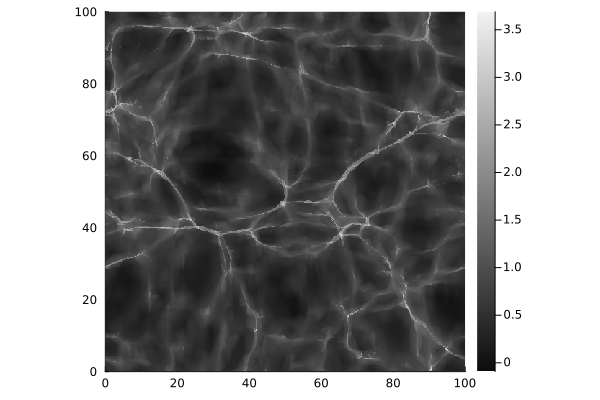

In [6]:
Range = 0.:0.2:100.

coords_arr  = [[L/2., y, z] for y in Range, z in Range]

density_field = density_subbox(coords_arr,  ps_dtfe_sb)

heatmap(Range, Range,log10.(density_field), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays) 

The evaluation of the number of streams and velocity fields is analogous with the `numberOfStreams_subbox()`, `velocity_subbox()` and the `velocitySum_subbox()` functions. 